Epoch 1/25
314/314 [==============================] - 334s 1s/step - loss: 0.9697 - accuracy: 0.7065 - val_loss: 12.0199 - val_accuracy: 0.1516
Epoch 2/25
314/314 [==============================] - 338s 1s/step - loss: 0.6974 - accuracy: 0.7742 - val_loss: 4.0014 - val_accuracy: 0.4576
Epoch 3/25
314/314 [==============================] - 329s 1s/step - loss: 0.5037 - accuracy: 0.8326 - val_loss: 1.9533 - val_accuracy: 0.6311
Epoch 4/25
314/314 [==============================] - 331s 1s/step - loss: 0.4294 - accuracy: 0.8558 - val_loss: 0.8753 - val_accuracy: 0.7982
Epoch 5/25
314/314 [==============================] - 338s 1s/step - loss: 0.3772 - accuracy: 0.8745 - val_loss: 1.8503 - val_accuracy: 0.6558
Epoch 6/25
314/314 [==============================] - 333s 1s/step - loss: 0.3437 - accuracy: 0.8864 - val_loss: 0.5580 - val_accuracy: 0.8428
Epoch 7/25
314/314 [==============================] - 337s 1s/step - loss: 0.3195 - accuracy: 0.8916 - val_loss: 0.4731 - val_accuracy: 0.885

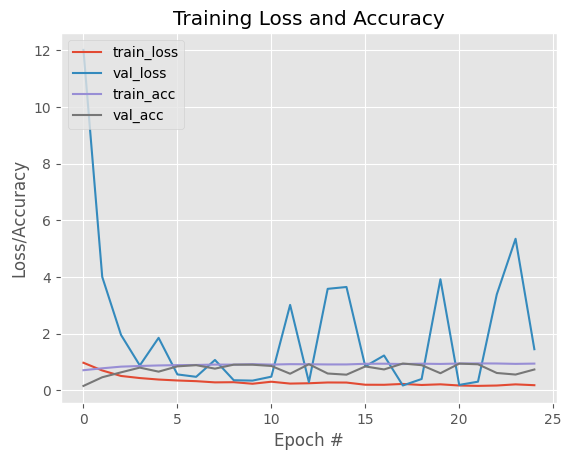

In [2]:
# Install necessary packages
!pip install tensorflow keras opencv-python matplotlib scikit-learn

# Import libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import legacy as legacy_optimizers  # Import legacy optimizers

# Adjusted load_images_from_folder function
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Ensure consistent class order
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (96, 96))
                    img = img.astype('float') / 255.0
                    images.append(img)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

# Define the path to the dataset (adjust this path to your dataset location)
dataset_path = '/content/drive/MyDrive/PlantVillage'

# Load dataset
X, y = load_images_from_folder(dataset_path)

# One-hot encode the labels
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(96, 96, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(lb.classes_)))
model.add(Activation("softmax"))

# Compile the model with the legacy Adam optimizer
opt = legacy_optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Data augmentation
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

# Train the model
EPOCHS = 25
BS = 32

H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS, verbose=1)

# Plot training and validation loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()


